In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../solver'))
from solver_rostering import Instance, Solver
from argparse import Namespace
import math

In [2]:
# Define model
base_file = 'berlin_db=0.50'
model = "flex"
outsourcing_cost_multiplier = 1.2
regional_multiplier = 1.5
global_multiplier = 0.8
h_min = 32
h_max = 48
max_n_diff = 3
max_n_shifts = 3

weekday_ = f'{base_file}_dt=doublepeak.json'
weekend_ = f'{base_file}_dt=uniform.json'

instance_file_weekday = f"../../instances/{weekday_}"
instance_file_weekend = f"../../instances/{weekend_}"

shift_file_weekday = f"../../shifts/{weekday_}"
shift_file_weekend = f"../../shifts/{weekend_}"

args = Namespace(
    model=model,
    instance_file_weekday=instance_file_weekday,
    shift_file_weekday = shift_file_weekday,
    instance_file_weekend=instance_file_weekend,
    shift_file_weekend = shift_file_weekend,
    workforce_dict = {0:1, 1:1, 2:1, 3:1, 4:1, 5:1},

    outsourcing_cost_multiplier=outsourcing_cost_multiplier,
    regional_multiplier=regional_multiplier,
    global_multiplier=global_multiplier,

    h_min = h_min,
    h_max = h_max,
    max_n_diff = max_n_diff,
    max_n_shifts=max_n_shifts
)

In [3]:
def workforce_size(args):
    objective_value = float('inf')
    objective_value_list = []
    workforce_size_list = []
    change = 0
    size = 1

    # Build initial workforce size dictionary
    i = Instance(args=args)
    workforce_dict = {}
    for region in i.population.keys():
        workforce_dict[region] = 1

    args.workforce_dict = workforce_dict
    
    # Optimize workforce sizing for first region
    while change <= 0:
        args.workforce_dict[0] = size
        i = Instance(args=args)
        solver = Solver(args=args, i=i)
        results = solver.solve_roster_objval()
        
        # Check if the objective value is nan
        if math.isnan(results['objective_value'][0]):
            break
        else:
            change = results['objective_value'][0] - objective_value
            objective_value = results['objective_value'][0]
            objective_value_list.append(objective_value)
            workforce_size_list.append(size)
            size += 1

    # Scale the workforce size for the other regions
    workforce_size_region_0 = workforce_size_list[-2]
    population = i.population
    for region in workforce_dict.keys():
        workforce_dict[region] = math.floor(population[region] * workforce_size_region_0 / population[0])

    return workforce_dict, objective_value, workforce_size_list , objective_value_list

In [4]:
size, obj, size_list, obj_list = workforce_size(args=args)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-12
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 99516 rows, 102471 columns and 120007 nonzeros
Model fingerprint: 0x93fc4993
Variable types: 99120 continuous, 3351 integer (3351 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 99516 rows and 102471 columns
Presolve time: 0.04s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.08 seconds (0.08 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 3520.48 

Optimal solution found (tolerance 1.00e-04)
Best objective

KeyboardInterrupt: 

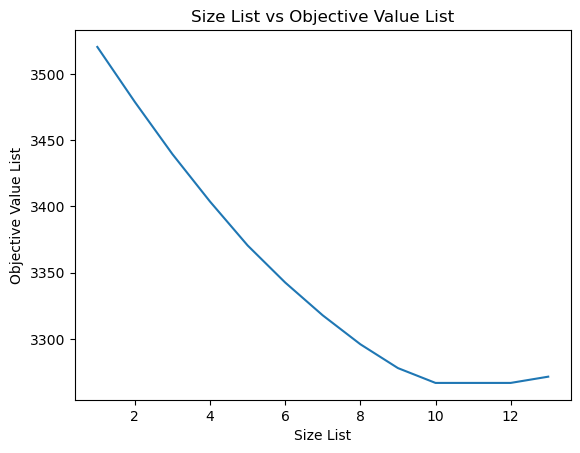

In [ ]:
import matplotlib.pyplot as plt

plt.plot(size_list, obj_list)
plt.xlabel('Size List')
plt.ylabel('Objective Value List')
plt.title('Size List vs Objective Value List')
plt.show()